## Exploratory code for estimating visit distribution of QPN data
- Objectives
    - Compare inter-datatype (e.g. MRI vs MoCA) intervals
    - Compare inter-visit intervals (e.g. MRI01 vs MRI02)
- Datatypes
    - MRI
    - Clinical: UPDRS, MoCA, Neuropsy
- Visits: Most datatypes have 1 or 2 visits. MoCA has 3 visits at times. 
- Naming 
    - screening --> date of recruitment
    - baseline --> date of first data collection (earliest across all datatypes)
    - Visit_ID --> index number for ad-hoc modality collection (i.e. MRI01, MRI02)
    - Event_ID --> index corresponding to a time-interval measured relative to baseline

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from itertools import combinations

## Visits CSV
- Source: dashboard for MRI + clinical data

In [2]:
# Current recruit manifest
releases_dir = "/home/nikhil/projects/Parkinsons/qpn/releases/"
current_release = "Apr_2022"

In [9]:
current_recruit_manifest_xls = f"{releases_dir}{current_release}/tabular/QPN_Imaging_Codes.xlsx"

sheet_name = "Dashboard" #"recruit_manifest"

assessment_dict = {
    "MRI": ["MRI"],
    "clinical": ["Neuropsy","TUG","UPDRS","MoCA"]
}

# useful cols
useful_cols = {"MRI Time 1": "MRI_V1", "MRI Time 2": "MRI_V2", 
            "Neuropsy Time 1":"Neuropsy_V1", "Neuropsy Time 2":"Neuropsy_V2", 
            "TUG Time 1": "TUG_V1", "TUG Time 2": "TUG_V2",
            "UPDRS (part III) Time 1":"UPDRS_V1", "UPDRS (part III) Time 2":"UPDRS_V2",
            "MoCA Time 1":"MoCA_V1", "MoCA Time 2":"MoCA_V2","MoCA time 3":"MoCA_V3"}

column_list = ["participant_id"] + list(useful_cols.keys())

dashboard_df = pd.read_excel(current_recruit_manifest_xls,sheet_name=sheet_name, engine='openpyxl',usecols=column_list)

visits_df = dashboard_df.dropna(how="all", axis=0)
visits_df = visits_df.rename(columns=useful_cols)
for col in useful_cols.values():
    visits_df[col] = pd.to_datetime(visits_df[col],errors="coerce", dayfirst=True) #Note: format="%d-%m-%Y" skips MRI02 dates
    visits_df[col] = pd.to_datetime(visits_df[col],errors="coerce", format="%d-%m-%Y") # reformatting to be compatible with np.datetime64

mr_proc_participants_current = visits_df["participant_id"].dropna().unique()
n_mr_proc_participants_current = len(mr_proc_participants_current)
print(f"number of participants from current mr_proc release: {n_mr_proc_participants_current}")


# set baseline date
visits_df = visits_df.set_index("participant_id")
visits_df["baseline"] = visits_df.min(axis=1)

visits_df.head()

number of participants from current mr_proc release: 208


,MRI_V1,MRI_V2,Neuropsy_V1,Neuropsy_V2,UPDRS_V1,UPDRS_V2,MoCA_V1,MoCA_V2,MoCA_V3,TUG_V1,TUG_V2,baseline
participant_id,,,,,,,,,,,,
MNI0056,2021-08-18,NaT,2021-07-30,NaT,2021-06-11,NaT,NaT,NaT,NaT,2021-09-03,NaT,2021-06-11
MNI0058,2021-08-18,NaT,2021-08-18,NaT,2021-07-23,NaT,NaT,NaT,NaT,2021-07-23,NaT,2021-07-23
MNI0068,2021-08-27,NaT,2021-08-18,NaT,2021-08-27,NaT,NaT,NaT,NaT,NaT,NaT,2021-08-18
MNI0079,2021-12-22,NaT,2022-01-21,NaT,2022-01-21,NaT,NaT,NaT,NaT,2021-07-02,NaT,2021-07-02
MNI0103,2021-11-08,NaT,2021-10-01,NaT,2021-10-01,NaT,NaT,NaT,NaT,NaT,NaT,2021-10-01


In [24]:
dashboard_df.set_index("participant_id").loc["MNI0148"]["MoCA Time 1"]

'27-08-2021'

In [27]:
visits_df.loc["MNI0148"]["MoCA_V1"]

NaT

In [10]:
visits_df.describe(datetime_is_numeric=True)

,MRI_V1,MRI_V2,Neuropsy_V1,Neuropsy_V2,UPDRS_V1,UPDRS_V2,MoCA_V1,MoCA_V2,MoCA_V3,TUG_V1,TUG_V2,baseline
count,208,16,193,23,157,37,0,0,3,37,5,208
mean,2020-10-05 02:39:13.846153728,2022-04-20 21:00:00,2020-09-25 15:10:15.544041472,2022-04-09 12:31:18.260869632,2020-07-27 07:47:46.242038272,2021-12-25 23:21:04.864864768,NaT,NaT,2021-01-20 16:00:00,2021-08-04 05:50:16.216216320,2022-03-12 14:24:00,2020-08-16 09:48:27.692307712
min,2018-07-24 00:00:00,2021-12-13 00:00:00,2018-07-31 00:00:00,2021-05-21 00:00:00,2018-03-12 00:00:00,2021-02-08 00:00:00,NaT,NaT,2018-08-15 00:00:00,2021-02-05 00:00:00,2022-02-11 00:00:00,2018-03-12 00:00:00
25%,2019-08-16 00:00:00,2022-02-27 12:00:00,2019-08-02 00:00:00,2022-01-14 00:00:00,2019-08-02 00:00:00,2021-09-22 00:00:00,NaT,NaT,2020-06-07 12:00:00,2021-05-28 00:00:00,2022-02-14 00:00:00,2019-07-30 00:00:00
50%,2021-04-16 12:00:00,2022-04-29 00:00:00,2021-02-24 00:00:00,2022-05-25 00:00:00,2020-12-03 00:00:00,2022-01-07 00:00:00,NaT,NaT,2022-04-01 00:00:00,2021-07-09 00:00:00,2022-03-11 00:00:00,2020-12-07 12:00:00
75%,2021-10-06 06:00:00,2022-05-31 18:00:00,2021-10-06 00:00:00,2022-07-13 00:00:00,2021-07-19 00:00:00,2022-04-29 00:00:00,NaT,NaT,2022-04-10 12:00:00,2021-09-22 00:00:00,2022-03-23 00:00:00,2021-08-05 12:00:00
max,2022-08-31 00:00:00,2022-08-10 00:00:00,2022-08-26 00:00:00,2022-11-03 00:00:00,2022-07-29 00:00:00,2022-08-10 00:00:00,NaT,NaT,2022-04-20 00:00:00,2022-06-15 00:00:00,2022-04-29 00:00:00,2022-08-31 00:00:00


In [5]:
visits_df[visits_df["baseline"] < np.datetime64('2018-06-01')]

,MRI_V1,MRI_V2,Neuropsy_V1,Neuropsy_V2,UPDRS_V1,UPDRS_V2,MoCA_V1,MoCA_V2,MoCA_V3,TUG_V1,TUG_V2,baseline
participant_id,,,,,,,,,,,,
PD01199,2018-10-25,2022-04-28,2018-12-03,2022-04-01,2018-03-12,2021-09-07,NaT,NaT,2022-04-01,2021-07-09,NaT,2018-03-12


## Days since baseline

In [17]:
delta_df = pd.DataFrame()

for col in useful_cols.values():
    df = pd.DataFrame()
    df["days since baseline"] = visits_df[col] - visits_df["baseline"]
    df["assessment"] = col.split("_")[0]
    df["Visit_ID"] = col.split("_")[1]
    delta_df = delta_df.append(df)

Visit_ID_list = delta_df["Visit_ID"].unique()
print(f"Available visits: {Visit_ID_list}")
V3_ids = delta_df[(delta_df["Visit_ID"]=="V3") & 
                  (~delta_df["days since baseline"].isna())].reset_index()["participant_id"].values
print(f"V3_ids: {V3_ids}")
delta_df.head()

Available visits: ['V1' 'V2' 'V3']
V3_ids: ['PD00119' 'PD01199' 'PD01277']


,days since baseline,assessment,Visit_ID
participant_id,,,
MNI0056,68 days,MRI,V1
MNI0058,26 days,MRI,V1
MNI0068,9 days,MRI,V1
MNI0079,173 days,MRI,V1
MNI0103,38 days,MRI,V1


### Days since first visit (V1) for each datatype

In [18]:
delta_df = delta_df.reset_index().set_index(["participant_id","assessment"])

for vid in Visit_ID_list:
    delta_df.loc[delta_df["Visit_ID"]==vid, "days since V1"] = \
                    delta_df[delta_df["Visit_ID"]==vid]["days since baseline"] \
                   - delta_df[delta_df["Visit_ID"]=="V1"]["days since baseline"]

### Plot days since baseline for each participant

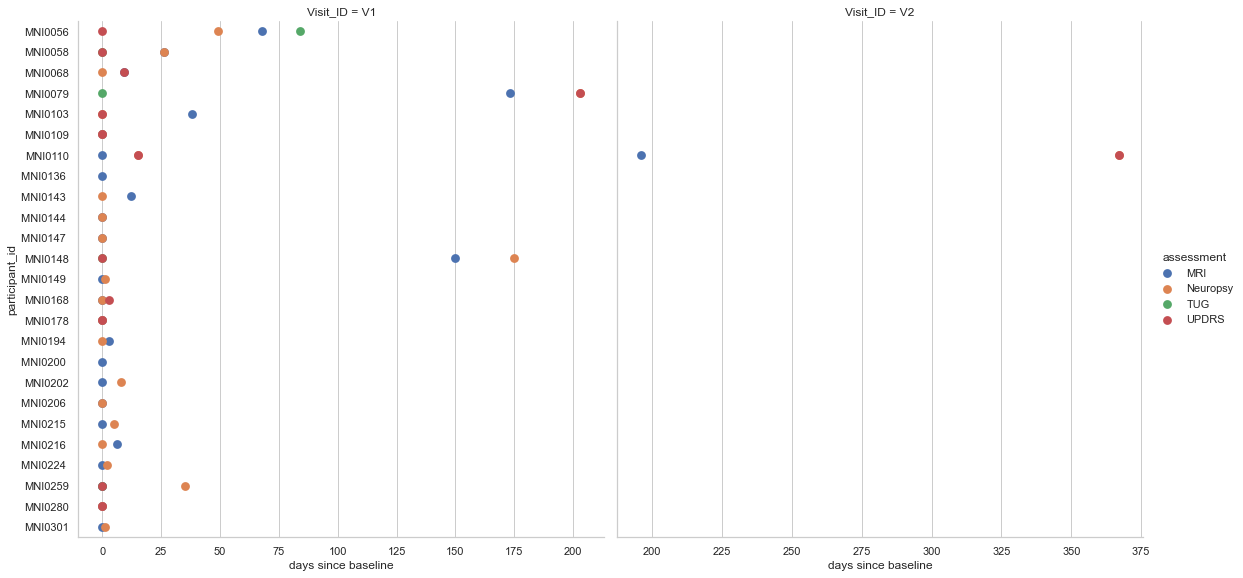

In [20]:
n_samples = 25 # to make plot readable

plot_df = delta_df.copy().reset_index()
plot_df = plot_df.fillna(datetime.timedelta(days=-1))
plot_df["days since baseline"] = (plot_df["days since baseline"] / np.timedelta64(1, 'D')).astype(int)
plot_df = plot_df[plot_df["days since baseline"] > -1]

sample_participants = list(plot_df["participant_id"].unique())[:n_samples]
plot_df = plot_df[plot_df["participant_id"].isin(sample_participants)]
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    kwargs = {'join':False, "marker":"d", "scale":1, "linewidth":0}
    g = sns.catplot(y="participant_id", x="days since baseline", hue="assessment", col="Visit_ID",
                kind="point", height=8, aspect=1, data=plot_df, sharex=False,
                **kwargs)

### anachronistic subjects

In [21]:
anachronistic_ids = delta_df[(delta_df["Visit_ID"]!="V1") & 
                             (delta_df["days since baseline"] < np.timedelta64(10, 'D'))
                             ].reset_index()["participant_id"]

visits_df.loc[anachronistic_ids]

,MRI_V1,MRI_V2,Neuropsy_V1,Neuropsy_V2,UPDRS_V1,UPDRS_V2,MoCA_V1,MoCA_V2,MoCA_V3,TUG_V1,TUG_V2,baseline
participant_id,,,,,,,,,,,,
PD00119,2018-08-13,NaT,2018-08-15,NaT,2018-08-15,NaT,NaT,NaT,2018-08-15,NaT,NaT,2018-08-13


### Generate Event_ID

In [22]:
def get_occurances(df, period, unit, n_intervals):
    _df = df.copy()
    # Baseline only gets half the interval! 
    # e.g. E0: 0-1mo, E1: 1-3mo (centered @ 2mo), E2: 3-5mo (centered @ 4mo)
    half_period = 0.5 * period
    if half_period.is_integer():
        half_period = int(half_period)
        for i in range(n_intervals):
            if i == 0: 
                start = np.timedelta64(0, unit)
                end = np.timedelta64(half_period, unit)
            else:
                start = np.timedelta64(-half_period + i * period, unit)
                end = np.timedelta64(-half_period + (i+1) * period, unit)
            
            print(f"i={i}, center:{i * period}, start:{start}, end:{end}")
            _df.loc[((_df["days since baseline"] >= start) & \
                    (_df["days since baseline"] < end )),"Event_ID"] = f"E{i}"

    else:
        print(f"period: {period} needs to be divisible by 2 to create half-period for baseline")
        print(f"Not adding EventID")
    return _df


In [23]:
max_visit_interval = np.max(delta_df["days since baseline"])
event_interval = np.timedelta64(3, 'M')
n_intervals = int(np.ceil(max_visit_interval / event_interval))

print(f"max_visit_interval: {max_visit_interval}")
print(f"event_interval: {event_interval}")
print(f"n_intervals: {n_intervals}")

period = 6
unit = "M"
delta_df = get_occurances(delta_df, period, unit, n_intervals)
delta_df.head()

max_visit_interval: 1508 days 00:00:00
event_interval: 3 months
n_intervals: 17
i=0, center:0, start:0 months, end:3 months
i=1, center:6, start:3 months, end:9 months
i=2, center:12, start:9 months, end:15 months
i=3, center:18, start:15 months, end:21 months
i=4, center:24, start:21 months, end:27 months
i=5, center:30, start:27 months, end:33 months
i=6, center:36, start:33 months, end:39 months
i=7, center:42, start:39 months, end:45 months
i=8, center:48, start:45 months, end:51 months
i=9, center:54, start:51 months, end:57 months
i=10, center:60, start:57 months, end:63 months
i=11, center:66, start:63 months, end:69 months
i=12, center:72, start:69 months, end:75 months
i=13, center:78, start:75 months, end:81 months
i=14, center:84, start:81 months, end:87 months
i=15, center:90, start:87 months, end:93 months
i=16, center:96, start:93 months, end:99 months


,,days since baseline,Visit_ID,days since V1,Event_ID
participant_id,assessment,,,,
MNI0056,MRI,68 days,V1,0 days,E0
MNI0058,MRI,26 days,V1,0 days,E0
MNI0068,MRI,9 days,V1,0 days,E0
MNI0079,MRI,173 days,V1,0 days,E1
MNI0103,MRI,38 days,V1,0 days,E0


In [24]:
## Example participant
delta_df.loc["MNI0056"]

,days since baseline,Visit_ID,days since V1,Event_ID
assessment,,,,
MRI,68 days,V1,0 days,E0
MRI,NaT,V2,NaT,NaN
Neuropsy,49 days,V1,0 days,E0
Neuropsy,NaT,V2,NaT,NaN
TUG,84 days,V1,0 days,E0
TUG,NaT,V2,NaT,NaN
UPDRS,0 days,V1,0 days,E0
UPDRS,NaT,V2,NaT,NaN
MoCA,NaT,V1,NaT,NaN


### Group participants-->events-->assessments
- This is to check if multiple visits are in the same event span (e.g. baseline-3 mo, 3-9mo etc)

In [25]:
delta_df_count = delta_df.groupby(["participant_id","Event_ID","assessment"]).count()
visit_counts_per_event = delta_df_count["Visit_ID"].unique()

print(f"visit counts per assessment per event: {visit_counts_per_event}")

delta_df_count

visit counts per assessment per event: [1]


days since baseline  Visit_ID  \
participant_id Event_ID assessment                                  
MNI0056        E0       MRI                           1         1   
                        Neuropsy                      1         1   
                        TUG                           1         1   
                        UPDRS                         1         1   
MNI0058        E0       MRI                           1         1   
...                                                 ...       ...   
PD01759        E0       MRI                           1         1   
                        Neuropsy                      1         1   
UDM0045        E0       MRI                           1         1   
                        Neuropsy                      1         1   
                        UPDRS                         1         1   

                                    days since V1  
participant_id Event_ID assessment                 
MNI0056        E0       MRI                     1  
                        Neuropsy                1  
                        TUG                     1  
                        UPDRS                   1  
MNI0058        E0       MRI                     1  
...                                           ...  
PD01759        E0       MRI                     1  
                        Neuropsy                1  
UDM0045        E0       MRI                     1  
                        Neuropsy                1  
                        UPDRS                   1  

[679 rows x 3 columns]

## Get delta between visits

In [26]:
datatypes = ["MRI","Neuropsy","UPDRS","MoCA"]
visits = ["V1","V2"]

datatype_combinations = list(combinations(datatypes, 2))

# Diff datatypes
diff_df = pd.DataFrame()
for comb in datatype_combinations:
    col_1 = f"{comb[0]}_V1"
    col_2 = f"{comb[1]}_V1"
    diff_df[f"{col_1} - {col_2}"] = visits_df[col_1] - visits_df[col_2]

# Diff visits
for dt in datatypes:
    col_1 = f"{dt}_V2"
    col_2 = f"{dt}_V1"
    diff_df[f"{col_1} - {col_2}"] = visits_df[col_1] - visits_df[col_2]

diff_df.head()

,MRI_V1 - Neuropsy_V1,MRI_V1 - UPDRS_V1,MRI_V1 - MoCA_V1,Neuropsy_V1 - UPDRS_V1,Neuropsy_V1 - MoCA_V1,UPDRS_V1 - MoCA_V1,MRI_V2 - MRI_V1,Neuropsy_V2 - Neuropsy_V1,UPDRS_V2 - UPDRS_V1,MoCA_V2 - MoCA_V1
participant_id,,,,,,,,,,
MNI0056,19 days,68 days,NaT,49 days,NaT,NaT,NaT,NaT,NaT,NaT
MNI0058,0 days,26 days,NaT,26 days,NaT,NaT,NaT,NaT,NaT,NaT
MNI0068,9 days,0 days,NaT,-9 days,NaT,NaT,NaT,NaT,NaT,NaT
MNI0079,-30 days,-30 days,NaT,0 days,NaT,NaT,NaT,NaT,NaT,NaT
MNI0103,38 days,38 days,NaT,0 days,NaT,NaT,NaT,NaT,NaT,NaT


### Plot distribution of inter-datatype and inter-visit durations

<AxesSubplot:ylabel='participant_id'>

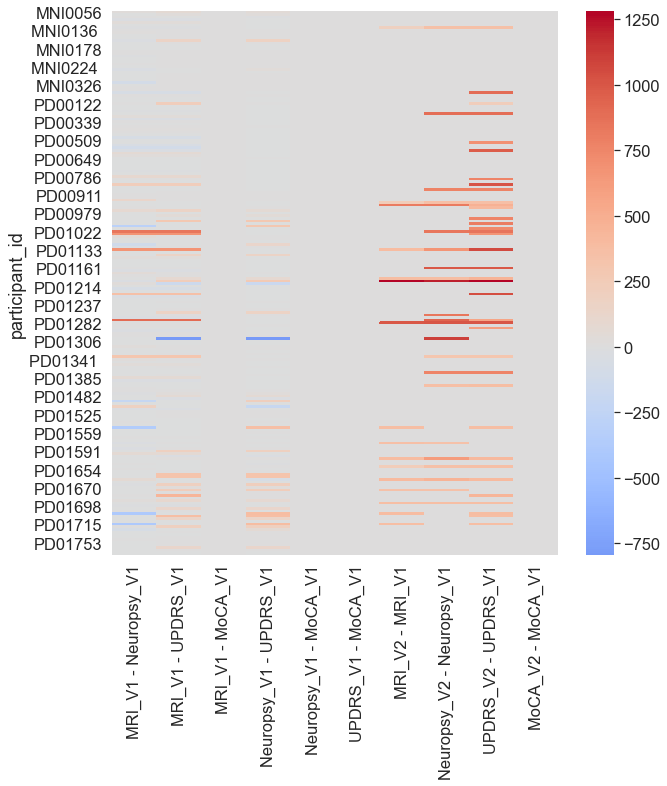

In [27]:
plot_df = diff_df.copy()
plot_df = plot_df.fillna(datetime.timedelta(days=1))
plot_df = (plot_df / np.timedelta64(1, 'D')).astype(int)

plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)
sns.heatmap(plot_df, cmap='coolwarm',center=0
            # annot=False,
            # fmt='.5g',
            )